In [292]:
import statsmodels.formula.api as smf
import sklearn
import sklearn.tree
import sklearn.ensemble
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [243]:
df=pd.read_csv('data/dev/dev-clean-whisper-large-v2-hypotheses.csv')
test_df=pd.read_csv('data/test/test-clean-whisper-large-v2-hypotheses.csv')
df.head()

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78


Notice how imbalanced the dataset is: there are far more hits than insertions or substitutions.

In [244]:
df.shape

(55242, 10)

In [245]:
df['edit_type'].value_counts(), len(df), df['edit_type'].value_counts()/len(df)

(edit_type
 0.0    53708
 1.0      886
 3.0      648
 Name: count, dtype: int64,
 55242,
 edit_type
 0.0    0.972231
 1.0    0.016039
 3.0    0.011730
 Name: count, dtype: float64)

# Data preprocessing
- Represent Part of Speech as one-hot column
- Add feature for word length
- Add feature for word==next/prev_word
- Add Zipf frequencies for start/end of sentence tokens.

There are three "Part of Speech" columns: `word_pos` (for the current word), `prev_word_pos` and `next_word_pos`.
Generate list of all unique parts of speech from across all three columns.

In [246]:
all_pos = set()
pos_cols = [col for col in df.columns if col.endswith('pos')]
for col in pos_cols:
    all_pos.update(df[col].unique())
    all_pos.update(test_df[col].unique())
all_pos = list(all_pos)+['<s>', '</s>']
all_pos.sort()

all_pos

['$',
 '.',
 '</s>',
 '</s>',
 '<s>',
 '<s>',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'MD',
 'NN',
 'NNP',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

To use Part of Speech as a feature for training, we need to represent it numerically in some way, since it's a categorical variable. Let's create a one-hot encoding by making a separate column for each part of speech.

In [247]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_df.columns.tolist()
df=pd.concat([df, pos_onehot_df], axis=1)
df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82,...,0,1,0,0,0,0,0,0,0,0
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27,...,0,0,0,0,0,0,0,0,0,0
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36,...,0,0,0,0,0,0,0,0,0,0
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36,...,0,0,0,0,0,0,0,0,0,0
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55237,thy,love,knot,1.0,NN,NN,NN,4.11,5.82,3.72,...,0,0,0,0,0,0,0,0,0,0
55238,knot,thy,on,1.0,NN,NN,IN,3.72,4.11,6.91,...,0,0,0,0,0,0,0,0,0,0
55239,on,knot,her,1.0,IN,NN,PRP$,6.91,3.72,6.30,...,0,0,0,0,0,0,0,0,0,0
55240,her,on,more,1.0,PRP,IN,JJR,6.30,6.91,6.36,...,0,0,0,0,0,0,0,0,0,0


Do the same for the test set

In [248]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = test_df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_test_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_test_df.columns.tolist()
test_df=pd.concat([test_df, pos_onehot_test_df], axis=1)
test_df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,concord,<s>,returned,0.0,NN,<s>,VBN,3.47,-1.00,4.82,...,0,0,0,1,0,0,0,0,0,0
1,returned,concord,to,0.0,VBD,NN,TO,4.82,3.47,7.43,...,0,0,0,0,0,0,0,0,0,0
2,to,returned,its,0.0,TO,VBD,PRP$,7.43,4.82,6.14,...,0,0,0,0,0,0,0,0,0,0
3,its,to,place,0.0,PRP$,TO,NN,6.14,7.43,5.71,...,0,0,0,0,0,0,0,0,0,0
4,place,its,amidst,0.0,NN,PRP$,IN,5.71,6.14,3.56,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54455,him,in,thy,0.0,PRP,IN,JJ,6.11,7.27,4.11,...,0,0,0,0,0,0,0,0,0,0
54456,thy,him,fair,0.0,JJ,PRP,JJ,4.11,6.11,4.99,...,0,0,0,0,0,0,0,0,0,0
54457,fair,thy,appearance,0.0,JJ,JJ,NN,4.99,4.11,4.69,...,0,0,0,0,0,0,0,0,0,0
54458,appearance,fair,lies,0.0,NN,JJ,VBZ,4.69,4.99,4.73,...,0,0,0,0,0,1,0,0,0,0


Add feature for whether current word is the same as the previous or following word.
This is useful since Whisper often "hallucinates" repeated instances of a word that aren't present in the actual audio.

In [249]:
for split in [df, test_df]:
    split['prev_word_same']=(split['word']==split['prev_word']).astype(int)
    split['next_word_same']=(split['word']==split['next_word']).astype(int)
word_equal_cols = ['prev_word_same', 'next_word_same']
df[word_equal_cols].value_counts()

prev_word_same  next_word_same
0               0                 55161
                1                    27
1               0                    27
                1                    27
Name: count, dtype: int64

Start/end token frequencies are set to "-1" by default, since they don't have Zipf frequencies in the `wordfreq` package given that they aren't real words. This is not ideal, since it doesn't accurately reflect how often sentence edges occur. However, we can estimate sentence token frequencies within the LibriSpeech corpus by treating them as words that each occur once per sentence.

In [250]:
freq_cols = [col for col in df.columns if col.endswith('freq')]
df[freq_cols]

,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,6.69,-1.00,6.82
1,6.82,6.69,7.27
2,7.27,6.82,7.36
3,7.36,7.27,2.36
4,2.36,7.36,5.78
...,...,...,...
55237,4.11,5.82,3.72
55238,3.72,4.11,6.91
55239,6.91,3.72,6.30
55240,6.30,6.91,6.36


In [251]:
num_words = len(df)
num_sent = df['prev_word_pos_is_<s>'].value_counts()[1]
sent_token_freq=num_sent/num_words
sent_token_per_bill=sent_token_freq*10**9
sent_token_zipf_freq = np.log10(sent_token_per_bill)
for col in freq_cols:
    df.loc[df[col]==-1, col]=sent_token_zipf_freq
    test_df.loc[test_df[col]==-1, col]=sent_token_zipf_freq

Let's also add word length as a feature, since (presumably) longer words will be harder for the ASR model to predict correctly.

In [252]:
word_cols = [col for col in df.columns if col.endswith('word')]
wordlen_cols = []
for col in word_cols:
    wordlen_col=col+'_len'
    df[wordlen_col]=df[col].str.len()
    test_df[wordlen_col]=test_df[col].str.len()
    wordlen_cols.append(wordlen_col)
df[wordlen_cols]

,word_len,prev_word_len,next_word_len
0,2,3,3
1,3,2,2
2,2,3,1
3,1,2,7
4,7,1,5
...,...,...,...
55237,3,4,4
55238,4,3,2
55239,2,4,3
55240,3,2,4


In [282]:
feat_cols = wordlen_cols+word_equal_cols+pos_onehot_cols+freq_cols
df[feat_cols].shape

(55242, 119)

### Upsampling


In [284]:
from sklearn.utils import resample

df_0 = df[df['edit_type'] == 0]  
df_1 = df[df['edit_type'] == 1] 
df_2 = df[df['edit_type'] == 3]

# only upsampling to a portion of the majority class
target_1 = int(len(df_0) * 0.3)
target_3 = int(len(df_0) * 0.3)

# upsampling for minority class
df_1_upsampled = resample(df_1, replace=True, n_samples=target_1, random_state=42)
df_2_upsampled = resample(df_2, replace=True, n_samples=target_3, random_state=42)

df_upsampled = pd.concat([df_0, df_1_upsampled, df_2_upsampled])
df_upsampled = df_upsampled[feat_cols+['edit_type']]
df_upsampled['edit_type'].value_counts()

edit_type
0.0    53708
1.0    16112
3.0    16112
Name: count, dtype: int64

### SMOTE

In [285]:
from imblearn.over_sampling import SMOTE

X_smote = df[feat_cols]
y_smote = df["edit_type"]

y = df.edit_type
majority_n = sum(y == 0)

smote = SMOTE(sampling_strategy={1: int(majority_n * 0.3), 3: int(majority_n * 0.3)},random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)


df_resampled = pd.DataFrame(X_resampled, columns=feat_cols)
df_resampled["edit_type"] = y_resampled

pd.Series(y_resampled).value_counts()

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_31679/111232413.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled["edit_type"] = y_resampled


edit_type
0.0    53708
1.0    16112
3.0    16112
Name: count, dtype: int64

### ADASYN

In [286]:
from imblearn.over_sampling import ADASYN

X_ada = df[feat_cols]
y_ada = df["edit_type"]

adasyn = ADASYN(sampling_strategy={1: int(majority_n * 0.3), 3: int(majority_n * 0.3)},random_state=42)
X_re, y_re = adasyn.fit_resample(X_ada, y_ada)

df_ada = pd.DataFrame(X_re, columns=feat_cols)
df_ada["edit_type"] = y_re

pd.Series(y_re).value_counts()

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_31679/341453145.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ada["edit_type"] = y_re


edit_type
0.0    53708
3.0    16052
1.0    16018
Name: count, dtype: int64

# Model fitting

In [287]:

def fit_no_resample(depth: int):
    class_weight = 1-df['edit_type'].value_counts()/len(df)
    class_weight=dict(class_weight)

    X = df[feat_cols]
    y = df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error
    tree_clf_weighted = sklearn.tree.DecisionTreeClassifier(max_depth=depth, class_weight=class_weight)
    rf_clf_weighted = sklearn.ensemble.RandomForestClassifier(max_depth=depth, class_weight=class_weight) #increase max_depth of rf from 10 to 40
    tree_clf_weighted.fit(X, y)
    rf_clf_weighted.fit(X, y)
    return tree_clf_weighted, rf_clf_weighted

In [288]:
# upsampling data: overfitting(if use class weight)

def fit_upsample(depth):
    class_weight = 1-df_upsampled['edit_type'].value_counts()/len(df_upsampled)
    class_weight=dict(class_weight)
    X_upsample = df_upsampled[feat_cols]
    y_upsample = df_upsampled['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error
    tree_clf_upsample = sklearn.tree.DecisionTreeClassifier(max_depth=depth, class_weight=class_weight)
    rf_clf_upsample = sklearn.ensemble.RandomForestClassifier(max_depth=depth, class_weight=class_weight)
    tree_clf_upsample.fit(X_upsample, y_upsample)
    rf_clf_upsample.fit(X_upsample, y_upsample)
    return tree_clf_upsample, rf_clf_upsample

In [289]:
# SMOTE
def fit_smote(depth):
    class_weight = 1-df_resampled['edit_type'].value_counts()/len(df_resampled)
    class_weight=dict(class_weight)
    X_smote = df_resampled[feat_cols]
    y_smote = df_resampled['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error
    tree_clf_smote = sklearn.tree.DecisionTreeClassifier(max_depth=depth, class_weight=class_weight)
    rf_clf_smote = sklearn.ensemble.RandomForestClassifier(max_depth=depth, class_weight=class_weight)
    tree_clf_smote.fit(X_smote, y_smote)
    rf_clf_smote.fit(X_smote, y_smote)
    return tree_clf_smote, rf_clf_smote

In [290]:
# ADA
def fit_ada(depth):
    class_weight = 1-df_ada['edit_type'].value_counts()/len(df_ada)
    class_weight=dict(class_weight)
    X_ada = df_ada[feat_cols]
    y_ada = df_ada['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error
    tree_clf_ada = sklearn.tree.DecisionTreeClassifier(max_depth=depth, class_weight=class_weight)
    rf_clf_ada = sklearn.ensemble.RandomForestClassifier(max_depth=depth, class_weight=class_weight)
    tree_clf_ada.fit(X_ada, y_ada)
    rf_clf_ada.fit(X_ada, y_ada)
    return tree_clf_ada, rf_clf_ada

# Score Decision Tree

In [296]:
X_test = test_df[feat_cols]
y_test = test_df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error

scores = []

for depth in tqdm(range(1, 10)):
    for model_funct, strategy in [
        (fit_no_resample, 'class_weight'),
        (fit_upsample, 'upsample'),
        (fit_smote, 'smote'),
        (fit_ada, 'ada')
    ]:
        tree, rf = model_funct(depth)
        y_hat_tree = tree.predict(X_test)
        y_hat_rf = rf.predict(X_test)

        tree_f1 = sklearn.metrics.f1_score(y_test, y_hat_tree, average=None)
        rf_f1 = sklearn.metrics.f1_score(y_test, y_hat_rf, average=None)

        scores.append({
            "classifier": "tree",
            "resample_strat": strategy,
            "depth": depth,
            "hit_f1": tree_f1[0],
            "sub_f1": tree_f1[1],
            "ins_f1": tree_f1[2],
        })
        scores.append({
            "classifier": "rf",
            "resample_strat": strategy,
            "depth": depth,
            "hit_f1": rf_f1[0],
            "sub_f1": rf_f1[1],
            "ins_f1": rf_f1[2],
        })
score_df = pd.DataFrame(scores)


100%|██████████| 9/9 [01:29<00:00,  9.91s/it]


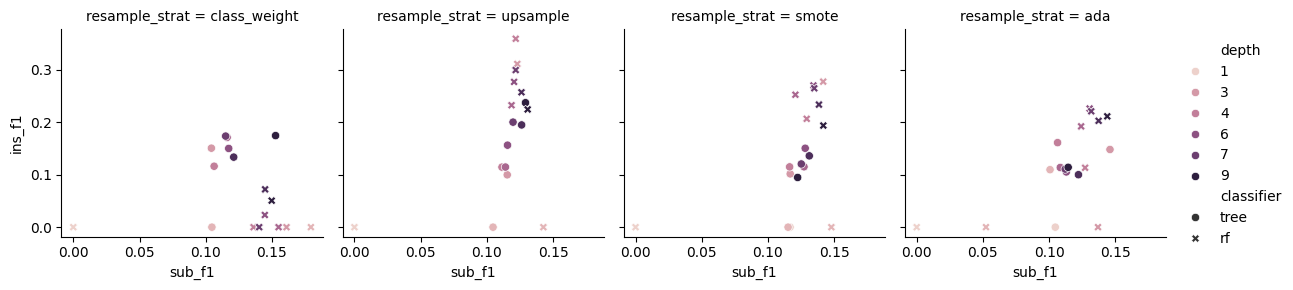

In [299]:
g=sns.FacetGrid(data=score_df, col='resample_strat')
g.map_dataframe(sns.scatterplot, x='sub_f1', y='ins_f1', hue='depth', style='classifier')
g.add_legend()
plt.show()